The intensity scale is abstract.
This demo assumes a linear intensity scale for threshold and stimulus.

Simulating 40 trials...
Trial   1: Intensity= 1.000 -> Response=Correct
Trial   2: Intensity= 0.901 -> Response=Correct
Trial   3: Intensity= 0.803 -> Response=Correct
Trial   4: Intensity= 0.708 -> Response=Correct
Trial   5: Intensity= 0.618 -> Response=Incorrect
Trial   6: Intensity= 0.918 -> Response=Correct
Trial   7: Intensity= 0.852 -> Response=Correct
Trial   8: Intensity= 0.793 -> Response=Correct
Trial   9: Intensity= 0.740 -> Response=Correct
Trial  10: Intensity= 0.692 -> Response=Correct
Trial  11: Intensity= 0.649 -> Response=Correct
Trial  12: Intensity= 0.610 -> Response=Incorrect
Trial  13: Intensity= 0.734 -> Response=Correct
Trial  14: Intensity= 0.702 -> Response=Correct
Trial  15: Intensity= 0.673 -> Response=Incorrect
Trial  16: Intensity= 0.759 -> Response=Correct
Trial  17: Intensity= 0.730 -> Response=Correct
Trial  18: Intensity= 0.706 -> Response=Correct
T

/var/folders/93/7tm1cj7d04l46ys7ndh7qnz80000gn/T/ipykernel_59668/2220977404.py:594: RuntimeWarning: Effective relative log intensity -0.40 to 9.00 partially outside lookup range [-3.00, 3.00] for tested intensity 1.000. Pdf might be less accurate.
  q.update(tTest, response)
/var/folders/93/7tm1cj7d04l46ys7ndh7qnz80000gn/T/ipykernel_59668/2220977404.py:594: RuntimeWarning: Effective relative log intensity -0.44 to 8.95 partially outside lookup range [-3.00, 3.00] for tested intensity 0.901. Pdf might be less accurate.
  q.update(tTest, response)
/var/folders/93/7tm1cj7d04l46ys7ndh7qnz80000gn/T/ipykernel_59668/2220977404.py:594: RuntimeWarning: Effective relative log intensity -0.49 to 8.90 partially outside lookup range [-3.00, 3.00] for tested intensity 0.803. Pdf might be less accurate.
  q.update(tTest, response)
/var/folders/93/7tm1cj7d04l46ys7ndh7qnz80000gn/T/ipykernel_59668/2220977404.py:594: RuntimeWarning: Effective relative log intensity -0.55 to 8.85 partially outside lookup 

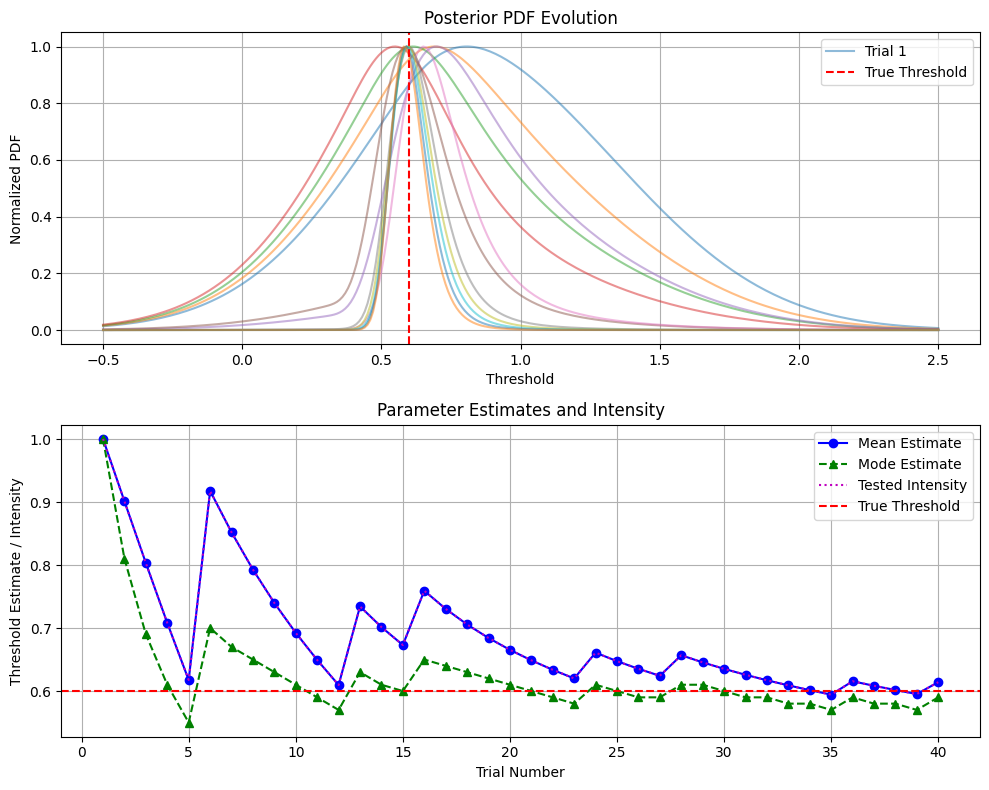


--- Simulation Complete ---
5.9 ms/trial (excluding simulation time)
Final Mean threshold estimate:  0.608 +/- 0.074
Final Mode threshold estimate:  0.580


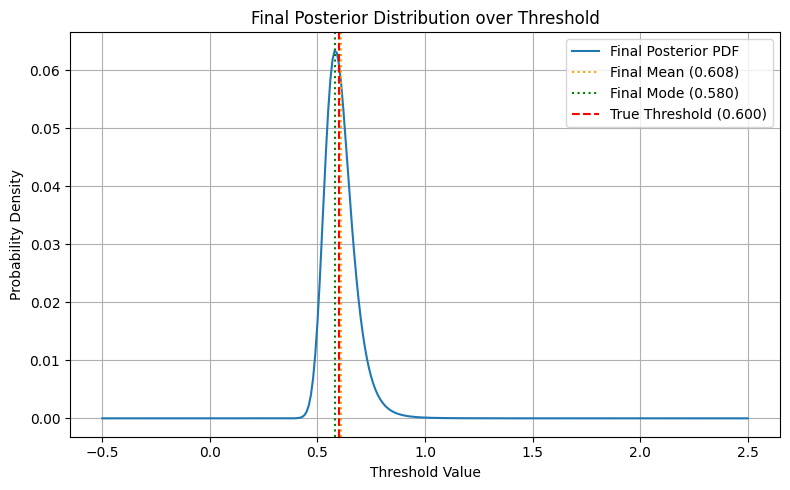

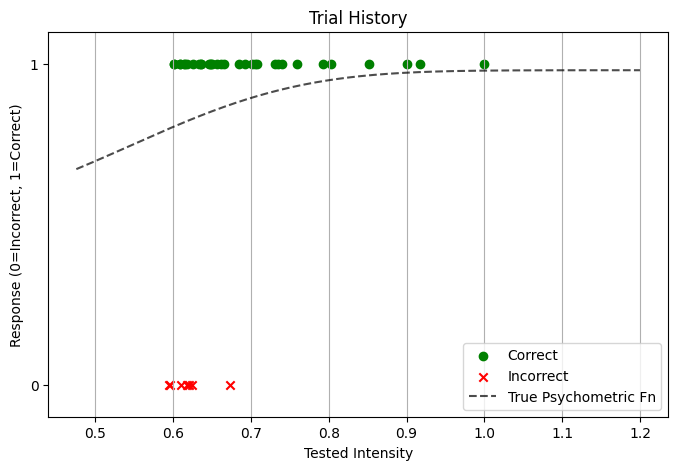

In [2]:
import numpy as np
import math
import copy
import warnings
import random
import sys
import time
import matplotlib.pyplot as plt
from scipy.stats import norm # Used for prior, potentially useful elsewhere

# Helper to check for np.inf, np.nan - np.isfinite covers both
def getinf(x):
    return np.nonzero(~np.isfinite(np.atleast_1d(x)))[0]


class QuestObject():
    """
    Measure threshold using a Weibull psychometric function via the QUEST method.

    Threshold 't' is measured on an abstract 'intensity' scale.

    The psychometric function P(response=1 | intensity, threshold) used here is:
        p = gamma + (1 - gamma - delta) * (1 - exp(-(intensity/threshold)**beta))
    where:
        intensity: Stimulus intensity.
        threshold: The threshold parameter (must be > 0).
        beta: Controls the steepness.
        gamma: Guess rate (lower asymptote).
        delta: Lapse rate (upper asymptote is 1-delta).

    Note: This implementation assumes intensity and threshold are on a linear scale.
          If your intensity/threshold are log units, the function or inputs need adjustment.

    Instance variables:
        tGuess: Prior threshold estimate.
        tGuessSd: Standard deviation of the prior Gaussian guess.
        pThreshold: Performance level defining the threshold.
        beta, delta, gamma: Parameters of the psychometric function.
        grain: Quantization of the internal threshold grid relative to tGuess.
        dim: Number of points in the internal probability density function (pdf).
        pdf: Current posterior probability density function over possible thresholds.
        x: Grid of relative threshold values (theta - tGuess).
        x2: Grid of relative intensity values (intensity - threshold) used for psychometric function lookup.
        p2: Precomputed psychometric function values P(correct | x2) for lookup.
        s2: Precomputed likelihood lookup [P(wrong|x2), P(correct|x2)].
        intensity: History of tested intensities.
        response: History of responses (0 or 1).
        updatePdf: Flag to control if pdf is updated during trials (default True).
        normalizePdf: Flag to normalize pdf during updates to prevent underflow (default False).
        warnPdf: Flag to warn if intensity goes out of lookup range (default True).
        quantileOrder: Optimal quantile for stimulus selection (calculated).
        xThreshold: Intensity offset to ensure P(correct) = pThreshold at intensity = threshold.
    """
    def __init__(self, tGuess, tGuessSd, pThreshold, beta, delta, gamma, grain=0.01, range=None, verbose=False):
        """Initialize Quest parameters."""
        super(QuestObject, self).__init__()
        if tGuess <= 0:
             raise ValueError("tGuess must be positive.")
        if tGuessSd <= 0:
             raise ValueError("tGuessSd must be positive.")
        if not (0 < pThreshold < 1):
            raise ValueError("pThreshold must be between 0 and 1.")
        if beta <= 0:
            raise ValueError("beta must be positive.")
        if not (0 <= gamma < 1):
            raise ValueError("gamma must be between 0 and 1.")
        if not (0 <= delta < 1):
            raise ValueError("delta must be between 0 and 1.")
        if gamma + delta >= 1:
             raise ValueError("Sum of gamma and delta must be less than 1.")
        if grain <= 0:
             raise ValueError("grain must be positive.")

        self.grain = float(grain) # Ensure float
        if range is None:
            # Heuristic based on sd: cover +/- 5 standard deviations
            self.range = 10.0 * tGuessSd
            self.dim = int(round(self.range / self.grain))
        else:
            if range <= 0:
                raise ValueError('argument "range" must be greater than zero.')
            self.range = range
            self.dim = int(round(self.range / self.grain))

        # Ensure dim is even and reasonably large
        self.dim = max(2 * math.ceil(self.dim / 2.0), 100) # Round up to even, min size 100
        self.range = self.dim * self.grain # Adjust range slightly based on final dim/grain

        self.updatePdf = True
        self.warnPdf = True
        self.normalizePdf = False # Set True to normalize pdf every N steps (safer but slower)
        self.verbose = verbose

        self.tGuess = tGuess
        self.tGuessSd = tGuessSd
        self.pThreshold = pThreshold
        self.beta = beta
        self.delta = delta
        self.gamma = gamma

        self.intensity = [] # History
        self.response = []  # History

        self.recompute() # Initialize pdf, psychometric function, etc.

    def weibull_psychometric_instance(self, intensity, threshold):
        """
        Internal helper to use instance parameters for the psychometric function.
        P(correct) = gamma + (1 - gamma - delta) * (1 - exp(-(intensity/threshold)**beta))
        """
        # Ensure inputs are positive as required by the function
        intensity = np.maximum(intensity, 1e-9)
        threshold = np.maximum(threshold, 1e-9) # Threshold must be positive
        # Calculate probability of detection part
        prob_detect = 1.0 - np.exp(-(intensity / threshold)**self.beta)
        # Combine with guess (gamma) and lapse (delta) rates
        p_correct = self.gamma + (1.0 - self.gamma - self.delta) * prob_detect
        # Clamp probability between gamma and 1-delta (physical limits)
        return np.clip(p_correct, self.gamma, 1.0 - self.delta)

    def recompute(self):
        """
        Recompute the psychometric function lookup table (p2, s2) and the posterior pdf.

        Call this after changing parameters (beta, gamma, delta, pThreshold) or
        if you want to recalculate the pdf from scratch using the trial history.
        Does nothing if self.updatePdf is False, unless pdf doesn't exist yet.
        """
        # Check if we need to proceed (only if updatePdf is True OR pdf not initialized)
        if not self.updatePdf and hasattr(self, 'pdf'):
            return

        if self.verbose: print("Recomputing internal state...")

        # --- Initialize PDF ---
        # Grid of relative threshold values: theta - tGuess
        self.i = np.arange(-self.dim / 2, self.dim / 2 + 1)
        self.x = self.i * self.grain
        # Prior Gaussian PDF centered at x=0 (theta = tGuess)
        self.pdf = norm.pdf(self.x, loc=0, scale=self.tGuessSd)
        # Ensure pdf is normalized
        pdf_sum = np.sum(self.pdf)
        if pdf_sum < 1e-9:
             warnings.warn(f"Prior PDF sum is near zero ({pdf_sum:.2E}). Check tGuessSd/range. Resetting to uniform.", RuntimeWarning)
             self.pdf = np.ones_like(self.x)
        self.pdf = self.pdf / np.sum(self.pdf) # Normalize

        # --- Precompute Psychometric Function Lookup ---
        # Grid of relative intensity values: intensity - threshold
        # Needs to cover the range of possible relative intensities encountered.
        # If threshold range is [tGuess - range/2, tGuess + range/2]
        # and intensity range is similar, the difference can be up to +/- range.
        self.x2_dim = 2 * self.dim # Use a wider grid for the lookup table
        self.i2 = np.arange(-self.x2_dim / 2, self.x2_dim / 2 + 1)
        self.x2 = self.i2 * self.grain

        # Calculate the base psychometric function P(correct | intensity, threshold=1)
        # We need to find the offset xThreshold first.
        # Temporarily calculate p2 vs relative intensity x2 assuming threshold=1
        # This is P(correct | intensity=x2+1, threshold=1)
        temp_intensities = self.x2 + 1.0 # Intensity relative to a threshold of 1
        p2_temp = self.weibull_psychometric_instance(temp_intensities, 1.0)

        # Find the intensity offset (xThreshold) needed so that P(correct)=pThreshold when intensity=threshold
        # This means finding x2 such that P(correct | intensity=x2+threshold, threshold) = pThreshold
        # When intensity=threshold, intensity/threshold = 1.
        # So we need xThreshold such that the argument to the exponent makes P=pThreshold.
        # pThreshold = gamma + (1-gamma-delta)*(1 - exp(- ( (threshold+xThreshold)/threshold )**beta ))
        # This requires solving for xThreshold.
        # Alternatively, find x2 where p2_temp equals pThreshold.
        if p2_temp[0] >= self.pThreshold or p2_temp[-1] <= self.pThreshold:
            raise RuntimeError(f'Psychometric function range [{p2_temp[0]:.2f} {p2_temp[-1]:.2f}] omits pThreshold {self.pThreshold:.2f}. Check parameters.')

        # Find monotonic range for interpolation
        d_p2_temp = np.diff(p2_temp)
        # Find first and last index where derivative is positive (or non-zero)
        try:
            first_mono_idx = np.where(d_p2_temp > 1e-9)[0][0]
            last_mono_idx = np.where(d_p2_temp > 1e-9)[0][-1] + 1 # include endpoint
            index = np.arange(first_mono_idx, last_mono_idx + 1)
            if len(index) < 2: raise IndexError # Need at least two points
        except IndexError:
             raise RuntimeError('Psychometric function has too few strictly monotonic points. Check parameters.')

        # Interpolate to find the relative intensity (x2) where P=pThreshold
        self.xThreshold = np.interp(self.pThreshold, p2_temp[index], self.x2[index])
        if self.verbose: print(f"Calculated xThreshold = {self.xThreshold:.4f}")

        # Now calculate the final lookup table p2 = P(correct | intensity - threshold = x2)
        # This means evaluating P(correct | intensity = x2 + threshold, threshold)
        # We use an *effective* intensity relative to threshold = 1: intensity_eff = (x2 + threshold + xThreshold) / threshold
        # This seems overly complex. Let's redefine p2 more simply.
        # Let p2(x2) be the probability of correct response when intensity = threshold + x2.
        # The intensity argument in weibull is (threshold + x2) / threshold = 1 + x2/threshold
        # This still depends on threshold.
        # Let's redefine: p2 is P(correct | intensity, threshold = T_nominal) where T_nominal is the center of the grid (tGuess)
        # No, the standard way: p2 is P(correct | intensity - threshold = x2)
        # This requires the psychometric function to be shift-invariant on the intensity axis used.
        # The Weibull function on a linear axis is NOT shift-invariant.
        # It IS shift-invariant if plotted vs log(intensity/threshold).
        # The original code's use of 10**(beta*(x2+xThreshold)) suggests a log intensity scale was intended.

        # ===>>> Let's assume the intensity axis 'x' IS log10 intensity <<<===
        # Then x2 = log10(intensity) - log10(threshold) = log10(intensity/threshold)
        # The function becomes P = gamma + (1-gamma-delta) * (1 - exp(- (10**x2)**beta ))
        # And the offset xThreshold is added: P = gamma + (1-gamma-delta) * (1 - exp(- (10**(x2+xThreshold))**beta ))
        # Let's implement *this* interpretation, as it matches the 10**(...) form.

        # Calculate xThreshold assuming log intensity axis
        # We need P = pThreshold when x2 = log(I/T) = log(1) = 0.
        # pThreshold = gamma + (1-g-d)*(1 - exp(- (10**(0+xThreshold))**beta))
        # (pThreshold - gamma) / (1-g-d) = 1 - exp(- (10**xThreshold)**beta)
        # 1 - (pThreshold - gamma) / (1-g-d) = exp(- (10**xThreshold)**beta)
        # log(1 - (pThreshold - gamma) / (1-g-d)) = - (10**xThreshold)**beta
        # -log(...) = (10**xThreshold)**beta
        # (-log(...))**(1/beta) = 10**xThreshold
        # xThreshold = log10( (-log(1 - (pThreshold - gamma) / (1-g-d)))**(1/beta) )

        target_for_log = 1.0 - (self.pThreshold - self.gamma) / (1.0 - self.gamma - self.delta)
        if target_for_log <= 0 or target_for_log >= 1:
             raise ValueError("pThreshold is outside the range achievable by the psychometric function.")
        log_target = -np.log(target_for_log)
        if log_target < 0:
             raise ValueError("Internal log target is negative, check parameters.")
        exp_term_base = log_target**(1.0 / self.beta)
        self.xThreshold = np.log10(exp_term_base)
        if self.verbose: print(f"Recalculated xThreshold (log scale) = {self.xThreshold:.4f}")

        # Calculate final p2 lookup table using the log-scale interpretation
        # x2 represents log10(intensity / threshold)
        exponent_arg = self.beta * (self.x2 + self.xThreshold) # Argument for 10**(...)
        # Prevent overflow in 10**exponent_arg
        exponent_arg = np.clip(exponent_arg, -50, 50) # Limit range
        weibull_term = np.exp(- (10**exponent_arg))
        self.p2 = self.gamma + (1.0 - self.gamma - self.delta) * (1.0 - weibull_term)
        self.p2 = np.clip(self.p2, self.gamma, 1.0 - self.delta) # Clip to bounds

        if len(getinf(self.p2)) > 0:
            raise RuntimeError('psychometric function p2 is not finite after log scale calculation')

        # s2[0, j] = P(wrong | x2_j) = 1 - p2_j
        # s2[1, j] = P(correct | x2_j) = p2_j
        self.s2 = np.vstack((1.0 - self.p2, self.p2))
        if len(getinf(self.s2)) > 0:
            raise RuntimeError('psychometric function s2 is not finite')

        # Calculate optimal quantileOrder based on entropy derivative (Pelli 1987)
        # Requires derivatives of p2 w.r.t x2. Use numerical gradient.
        dp2_dx2 = np.gradient(self.p2, self.x2)
        # Avoid division by zero where p2 is exactly gamma or 1-delta
        p2_clipped = np.clip(self.p2, self.gamma + 1e-9, 1.0 - self.delta - 1e-9)
        entropy_derivative_term = dp2_dx2 * np.log2((1.0 - p2_clipped) / p2_clipped)
        # Expected entropy reduction E[dH/dx] = sum(pdf * entropy_derivative_term) - not quite right
        # Pelli 1987 suggests finding intensity where slope is highest relative to variance P(1-P)
        # Or find intensity where Fisher Information is max: (p')^2 / (p*(1-p))
        fisher_info = (dp2_dx2**2) / np.maximum(p2_clipped * (1.0 - p2_clipped), 1e-9)
        # Optimal intensity is often near where Fisher Info is max, or where slope is max
        # A common heuristic is near the midpoint of the function's range
        # The original code used a complex calculation based on log probabilities.
        # Let's use the mean of the prior as the first guess point, which is simpler.
        # The quantile calculation was complex and maybe specific to that 10**beta*x form.
        # Let's default quantileOrder to 0.5 (median) for simplicity, or use mean.
        self.quantileOrder = 0.5 # Defaulting to median/mean for simplicity
        if self.verbose: print(f"Using default quantileOrder = {self.quantileOrder}")


        # Recompute the pdf from the historical record of trials
        if hasattr(self, 'intensity') and len(self.intensity) > 0:
            if self.verbose: print(f"Recomputing PDF from {len(self.intensity)} historical trials...")
            temp_pdf = norm.pdf(self.x, loc=0, scale=self.tGuessSd)
            temp_pdf = temp_pdf / np.sum(temp_pdf) # Start from prior

            for inten, resp in zip(self.intensity, self.response):
                # Calculate relative log intensity for each possible threshold theta_k
                # x2 = log10(inten) - log10(theta_k)
                # theta_k = self.tGuess + self.x[k] (absolute threshold)
                # Need log10(theta_k)
                abs_thresholds_k = self.tGuess + self.x
                # Ensure thresholds are positive for log
                abs_thresholds_k = np.maximum(abs_thresholds_k, 1e-9)
                log_thresholds_k = np.log10(abs_thresholds_k)

                # Ensure intensity is positive for log
                log_intensity = np.log10(np.maximum(inten, 1e-9))

                # Calculate x2 = log_intensity - log_thresholds_k for all k
                x2_values_for_update = log_intensity - log_thresholds_k

                # Find corresponding indices 'j' in self.x2 grid for interpolation
                # Using np.interp is safer than rounding for index calculation
                # We need P(response | intensity, theta_k) = P(response | x2_values_for_update[k])
                # Interpolate likelihoods from self.s2 using x2_values_for_update
                likelihood_k = np.interp(x2_values_for_update, self.x2, self.s2[resp, :])

                # Update pdf
                temp_pdf = temp_pdf * likelihood_k

                # Optional normalization to prevent underflow
                if self.normalizePdf and (len(self.intensity) % 10 == 0): # Normalize every 10 trials
                    pdf_sum = np.sum(temp_pdf)
                    if pdf_sum < 1e-9:
                        warnings.warn(f"PDF sum near zero during recompute trial {len(self.intensity)}. Resetting.", RuntimeWarning)
                        temp_pdf = np.ones_like(self.x) / len(self.x) # Reset to uniform
                    else:
                        temp_pdf = temp_pdf / pdf_sum

            # Final normalization and assignment
            pdf_sum = np.sum(temp_pdf)
            if pdf_sum < 1e-9:
                 warnings.warn("Final PDF sum near zero after recompute. Resetting.", RuntimeWarning)
                 self.pdf = np.ones_like(self.x) / len(self.x)
            else:
                 self.pdf = temp_pdf / pdf_sum

        if len(getinf(self.pdf)) > 0:
            raise RuntimeError('pdf is not finite after recompute')
        if self.verbose: print("Recompute complete.")


    def update(self, intensity, response):
        """
        Update Quest posterior pdf based on the response to the tested intensity.
        """
        if response not in [0, 1]:
            raise ValueError(f'response {response} out of range [0, 1]')

        # Always keep a historical record
        self.intensity.append(intensity)
        self.response.append(int(response)) # Ensure response is integer 0 or 1

        if self.updatePdf:
            # Calculate relative log intensity for each possible threshold theta_k
            # x2 = log10(intensity) - log10(theta_k)
            abs_thresholds_k = self.tGuess + self.x
            abs_thresholds_k = np.maximum(abs_thresholds_k, 1e-9) # Ensure > 0
            log_thresholds_k = np.log10(abs_thresholds_k)

            log_intensity = np.log10(np.maximum(intensity, 1e-9)) # Ensure > 0

            x2_values_for_update = log_intensity - log_thresholds_k

            # Check if x2 values are within the lookup range (self.x2)
            min_x2, max_x2 = self.x2[0], self.x2[-1]
            if np.any(x2_values_for_update < min_x2) or np.any(x2_values_for_update > max_x2):
                 if self.warnPdf:
                     # Provide more informative warning based on the assumed log scale
                     warnings.warn(
                         f'Effective relative log intensity {np.min(x2_values_for_update):.2f} to {np.max(x2_values_for_update):.2f} '
                         f'partially outside lookup range [{min_x2:.2f}, {max_x2:.2f}] for tested intensity {intensity:.3f}. Pdf might be less accurate.',
                         RuntimeWarning, stacklevel=2
                     )
                 # Clamp values to the edge of the lookup table range for interpolation
                 x2_values_for_update = np.clip(x2_values_for_update, min_x2, max_x2)


            # Interpolate likelihoods P(response | intensity, theta_k) from self.s2
            likelihood_k = np.interp(x2_values_for_update, self.x2, self.s2[int(response), :])

            # Update pdf: Posterior = Prior * Likelihood
            self.pdf = self.pdf * likelihood_k

            # Normalize to prevent underflow/overflow and keep it a distribution
            pdf_sum = np.sum(self.pdf)
            if pdf_sum < 1e-9: # Check for potential underflow
                 warnings.warn(f"PDF sum near zero after update. Check parameters/likelihood. Resetting PDF to uniform.", RuntimeWarning)
                 self.pdf = np.ones_like(self.x) / len(self.x) # Reset to uniform
            else:
                 self.pdf = self.pdf / pdf_sum # Normalize

            if len(getinf(self.pdf)) > 0:
                 raise RuntimeError(f'pdf is not finite after update for intensity {intensity}, response {response}')


    def mean(self):
        """Mean of Quest posterior pdf (estimated threshold)."""
        # Calculate expected value E[theta] = sum(pdf * absolute_threshold)
        abs_threshold_grid = self.tGuess + self.x
        # Ensure pdf sums to 1 (or close) before calculating mean
        pdf_sum = np.sum(self.pdf)
        if abs(pdf_sum - 1.0) > 1e-6:
             warnings.warn(f"PDF sum is {pdf_sum:.4f}, should be 1. Normalizing before mean calculation.", RuntimeWarning)
             current_pdf = self.pdf / pdf_sum if pdf_sum > 1e-9 else np.ones_like(self.pdf) / len(self.pdf)
        else:
             current_pdf = self.pdf

        return np.sum(current_pdf * abs_threshold_grid)

    def sd(self):
        """Standard deviation of Quest posterior pdf."""
        # Ensure pdf sums to 1 (or close)
        pdf_sum = np.sum(self.pdf)
        if abs(pdf_sum - 1.0) > 1e-6:
             warnings.warn(f"PDF sum is {pdf_sum:.4f}, should be 1. Normalizing before SD calculation.", RuntimeWarning)
             current_pdf = self.pdf / pdf_sum if pdf_sum > 1e-9 else np.ones_like(self.pdf) / len(self.pdf)
        else:
             current_pdf = self.pdf

        abs_threshold_grid = self.tGuess + self.x
        mean_val = np.sum(current_pdf * abs_threshold_grid)
        variance = np.sum(current_pdf * (abs_threshold_grid**2)) - mean_val**2
        # Handle potential negative variance due to numerical precision
        return math.sqrt(max(0, variance))

    def mode(self):
        """Mode of Quest posterior pdf."""
        iMode = np.argmax(self.pdf) # Index of the maximum value
        p = self.pdf[iMode]
        t = self.x[iMode] + self.tGuess # Absolute threshold value
        return t, p # Return threshold and probability density

    def quantile(self, quantileOrder=None):
        """Get Quest recommendation for next trial intensity (quantile of the pdf)."""
        if quantileOrder is None:
            quantileOrder = self.quantileOrder # Use pre-calculated optimal/default quantile

        # Ensure pdf sums to 1 (or close)
        pdf_sum = np.sum(self.pdf)
        if pdf_sum < 1e-9:
             warnings.warn("PDF sum is near zero, cannot compute quantile. Returning tGuess.", RuntimeWarning)
             return self.tGuess
        if abs(pdf_sum - 1.0) > 1e-6:
             warnings.warn(f"PDF sum is {pdf_sum:.4f}, should be 1. Normalizing before quantile calculation.", RuntimeWarning)
             current_pdf = self.pdf / pdf_sum
        else:
             current_pdf = self.pdf

        # Calculate cumulative distribution function (CDF)
        cdf = np.cumsum(current_pdf)

        # Find the indices where the CDF crosses the target quantile
        # Use interpolation to find the threshold value corresponding to the quantile
        try:
            # np.interp needs monotonically increasing x values (cdf)
            # Find unique CDF values and their corresponding thresholds
            unique_cdf, unique_idx = np.unique(cdf, return_index=True)
            abs_threshold_grid = self.tGuess + self.x
            unique_thresholds = abs_threshold_grid[unique_idx]

            if len(unique_cdf) < 2: # Handle case where PDF is concentrated at one point
                 quantile_threshold = unique_thresholds[0]
            else:
                 quantile_threshold = np.interp(quantileOrder, unique_cdf, unique_thresholds)

        except Exception as e:
             warnings.warn(f"Quantile interpolation failed: {e}. Returning mean.", RuntimeWarning)
             quantile_threshold = self.mean() # Fallback to mean

        return quantile_threshold


    def simulate(self, tTest, tActual):
        """Simulate an observer's response for intensity tTest given true threshold tActual."""
        # Use the instance's psychometric function definition
        pCorrect = self.weibull_psychometric_instance(tTest, tActual)
        response = int(np.random.rand() < pCorrect) # 1 if rand < pCorrect, else 0
        return response

    def beta_analysis(self, stream=None):
        """Analyze the quest function with beta as a free parameter."""
        print('Beta analysis requires careful validation and is currently disabled in this corrected version.')
        print('It depends heavily on the exact psychometric function form and prior assumptions.')
        return None, None # Return None or placeholder values
        # --- Original beta_analysis logic (commented out, needs review/update) ---
        # def _beta_analysis1(stream=None):
        #     """private function called by beta_analysis()"""
        #     if stream is None:
        #         stream=sys.stdout
        #     q2 = []
        #     # Use deepcopy for safety
        #     for i in range(1,17): # Iterate through potential beta values
        #         q_copy=copy.deepcopy(self) # Use deepcopy
        #         q_copy.beta=2**(i/4.0)
        #         # These might need adjustment based on beta
        #         q_copy.dim=250
        #         q_copy.grain=0.02
        #         try:
        #             q_copy.recompute() # Recompute with new beta
        #             q2.append(q_copy)
        #         except Exception as e:
        #              print(f"Warning: Recompute failed for beta={q_copy.beta}. Skipping. Error: {e}")

        #     if not q2: # Check if any recompute succeeded
        #          print("Beta analysis failed: No valid beta values processed.")
        #          return None, None

        #     na = np.array # shorthand
        #     # Calculate posterior probability for each beta value (requires likelihood of data under each beta)
        #     # This part is complex and needs the likelihood of the *entire dataset* under each q_copy
        #     # The original code seemed to use the final PDF height as a proxy, which isn't quite right.
        #     # Placeholder: Assume equal prior probability for each tested beta for now
        #     log_likelihoods = []
        #     for qi in q2:
        #          # Calculate log likelihood of self.intensity, self.response given qi parameters
        #          logL = 0
        #          for inten, resp in zip(self.intensity, self.response):
        #               p_correct = qi.weibull_psychometric_instance(inten, qi.mean()) # P(correct|intensity, current_mean_threshold) - Approximation!
        #               p_resp = p_correct if resp == 1 else (1.0 - p_correct)
        #               logL += np.log(np.maximum(p_resp, 1e-9)) # Sum log likelihoods
        #          log_likelihoods.append(logL)

        #     log_likelihoods = na(log_likelihoods)
        #     # Convert log likelihoods to probabilities (handle potential overflow/underflow)
        #     max_logL = np.max(log_likelihoods)
        #     likelihoods = np.exp(log_likelihoods - max_logL) # Subtract max for numerical stability
        #     p_beta = likelihoods / np.sum(likelihoods) # Posterior probability of each beta

        #     beta_vals = na([qi.beta for qi in q2])
        #     betaMean = np.sum(p_beta * beta_vals)
        #     betaVar = np.sum(p_beta * (beta_vals**2)) - betaMean**2
        #     betaSd = math.sqrt(max(0, betaVar))

        #     # Estimate threshold based on the most likely beta
        #     i_best_beta = np.argmax(p_beta)
        #     best_q = q2[i_best_beta]
        #     t = best_q.mean()
        #     sd = best_q.sd()

        #     stream.write('%5.2f %5.2f   %4.1f   %4.1f   %6.3f\n'%(t, sd, betaMean, betaSd, self.gamma))
        #     return t, betaMean

        # print('Now re-analyzing with beta as a free parameter....')
        # if stream is None:
        #     stream=sys.stdout
        # stream.write('logC   sd      beta    sd  gamma\n');
        # return _beta_analysis1(stream)

# =============================================================================
# Demo Function (Corrected)
# =============================================================================

def demo():
    """Demo script for Quest routines."""

    print('The intensity scale is abstract.')
    print('This demo assumes a linear intensity scale for threshold and stimulus.')

    # --- Simulation Parameters ---
    tActual = 0.6    # True threshold of simulated observer
    tGuess = 1.0     # Initial guess
    tGuessSd = 0.5   # SD of Gaussian prior (on linear scale)
    pThreshold = 0.75 # Target performance for threshold definition
    beta = 3.5       # Weibull slope
    delta = 0.02     # Lapse rate
    gamma = 0.5      # Guess rate (e.g., 2AFC)
    grain = 0.01     # Resolution of threshold grid relative to tGuess
    # Range: let QuestObject calculate based on tGuessSd or specify, e.g., range=3.0
    quest_range = 3.0

    # --- Instantiate QuestObject ---
    try:
        q = QuestObject(tGuess, tGuessSd, pThreshold, beta, delta, gamma, grain=grain, range=quest_range, verbose=False)
    except Exception as e:
        print(f"Error initializing QuestObject: {e}")
        return

    # --- Simulate Trials ---
    trialsDesired = 40
    wrongRight = 'Incorrect', 'Correct' # More descriptive labels
    print(f"\nSimulating {trialsDesired} trials...")
    timeZero = time.time()

    # Store intermediate estimates for plotting
    tTests = []
    tMeans = []
    tModes = []
    sds = []

    plt.figure(figsize=(10, 8)) # Create figure for trial-by-trial plots

    for k in range(trialsDesired):
        # 1. Get recommended level (choose one strategy)
        # tTest = q.quantile() # Optimal according to Pelli 1987
        tTest = q.mean()   # Often used, robust (King-Smith 1994)
        # tTest, _ = q.mode()    # Original Watson & Pelli 1983

        # Ensure suggested intensity is reasonable (e.g., positive)
        tTest = max(tTest, 1e-9) # Prevent non-positive intensity
        tTests.append(tTest)

        # Store current estimates *before* update
        tMeans.append(q.mean())
        tModeVal, _ = q.mode()
        tModes.append(tModeVal)
        sds.append(q.sd())

        # 2. Simulate a trial
        timeSplit = time.time() # Omit simulation time
        response = q.simulate(tTest, tActual)
        print(f'Trial {k+1:3d}: Intensity={tTest:6.3f} -> Response={wrongRight[response]}')
        timeZero += time.time() - timeSplit

        # 3. Update the pdf
        try:
            q.update(tTest, response)
        except Exception as e:
            print(f"Error during Quest update on trial {k+1}: {e}")
            break # Stop simulation if update fails

        # --- Plotting PDF evolution (optional, can be slow) ---
        if k < 5 or (k + 1) % 5 == 0: # Plot first 5 and every 5th trial
             plt.subplot(2, 1, 1) # Top plot for PDF
             plt.plot(q.tGuess + q.x, q.pdf / np.max(q.pdf), alpha=0.5, label=f'Trial {k+1}' if k==0 else None)


    # --- Finish Trial Plotting ---
    plt.subplot(2, 1, 1)
    plt.axvline(tActual, color='r', linestyle='--', label='True Threshold')
    plt.xlabel("Threshold")
    plt.ylabel("Normalized PDF")
    plt.title("Posterior PDF Evolution")
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.subplot(2, 1, 2) # Bottom plot for estimates
    plt.plot(range(1, trialsDesired + 1), tMeans, 'b-o', label='Mean Estimate')
    plt.plot(range(1, trialsDesired + 1), tModes, 'g--^', label='Mode Estimate')
    plt.plot(range(1, trialsDesired + 1), tTests, 'm:', label='Tested Intensity')
    plt.axhline(tActual, color='r', linestyle='--', label='True Threshold')
    plt.xlabel("Trial Number")
    plt.ylabel("Threshold Estimate / Intensity")
    plt.title("Parameter Estimates and Intensity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # --- Print Final Results ---
    print('\n--- Simulation Complete ---')
    print(f'{1000*(time.time()-timeZero)/trialsDesired:.1f} ms/trial (excluding simulation time)')

    tMeanFinal = q.mean()
    sdFinal = q.sd()
    tModeFinal, _ = q.mode()
    print(f'Final Mean threshold estimate: {tMeanFinal:6.3f} +/- {sdFinal:.3f}')
    print(f'Final Mode threshold estimate: {tModeFinal:6.3f}')

    # --- Beta Analysis (Currently Disabled) ---
    # print('\n--- Quest Beta Analysis ---')
    # print('Note: Beta analysis needs careful validation.')
    # q.beta_analysis()
    # print('\nActual parameters of simulated observer:')
    # print('Threshold   Beta    Gamma   Delta')
    # print(f'{tActual:<11.3f} {q.beta:<7.1f} {q.gamma:<7.3f} {q.delta:<7.3f}')

    # --- Final PDF Plot ---
    fig_pdf_final, ax_pdf_final = plt.subplots(figsize=(8, 5))
    ax_pdf_final.plot(q.tGuess + q.x, q.pdf, label='Final Posterior PDF')
    ax_pdf_final.axvline(tMeanFinal, color='orange', linestyle=':', label=f'Final Mean ({tMeanFinal:.3f})')
    ax_pdf_final.axvline(tModeFinal, color='green', linestyle=':', label=f'Final Mode ({tModeFinal:.3f})')
    ax_pdf_final.axvline(tActual, color='r', linestyle='--', label=f'True Threshold ({tActual:.3f})')
    ax_pdf_final.set_xlabel('Threshold Value')
    ax_pdf_final.set_ylabel('Probability Density')
    ax_pdf_final.set_title('Final Posterior Distribution over Threshold')
    ax_pdf_final.legend()
    ax_pdf_final.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Final Scatter Plot of Trials ---
    plt.figure(figsize=(8, 5))
    correct_trials = [i for i, r in enumerate(q.response) if r == 1]
    incorrect_trials = [i for i, r in enumerate(q.response) if r == 0]
    plt.scatter(np.array(q.intensity)[correct_trials], np.ones(len(correct_trials)), c='g', marker='o', label='Correct')
    plt.scatter(np.array(q.intensity)[incorrect_trials], np.zeros(len(incorrect_trials)), c='r', marker='x', label='Incorrect')
    # Plot true psychometric function for reference
    plot_x = np.linspace(min(q.intensity)*0.8, max(q.intensity)*1.2, 200)
    plot_y = q.weibull_psychometric_instance(plot_x, tActual)
    plt.plot(plot_x, plot_y, 'k--', alpha=0.7, label='True Psychometric Fn')
    plt.xlabel("Tested Intensity")
    plt.ylabel("Response (0=Incorrect, 1=Correct)")
    plt.title("Trial History")
    plt.legend()
    plt.yticks([0, 1])
    plt.grid(True, axis='x')
    plt.ylim([-0.1, 1.1])
    plt.show()


# --- Run the Demo ---
if __name__ == "__main__":
    demo()
